In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import dateutil.parser
import time
from pandas import DataFrame
import datetime

import os

from scipy.special import gamma

import matplotlib.pyplot as plt
import Visualization

# Evaluación estadístico de salto
---
En este notebook evaluaremos el estadístico de salto definido en Dungey 2009 como:

$$JS_{t+1}(\delta)=\frac{RV_{t+1}(\delta)-BV_{t+1}(\delta)}{\sqrt{(\mu_1^{-4}+2\mu_1^{-2}-5) \max\{1, TQ_{t+1}(\delta)BV_{t+1}(\delta)^{-2}\}}}$$

Comenzamos definiendo una función que particiona los datos por días. Luego, iremos definiendo los parámetros de volatilidad realizada, bi-power variation y tri-power quarticity necesarios para evaluar el estadístico.

In [2]:
# Funcion que retorna una lista con entradas que corresponden a los datos de un dia para una accion

def sep_date(stockdata):
    #days = GetDate(stockdata)
    days = stockdata["dia"].drop_duplicates(keep="first").values
    daily_dfs = []
    for i in days:
        daily_dfs.append(stockdata.loc[stockdata["dia"] == i])
    return daily_dfs

La volatilidad realizada será: $$RV_{t+1}(\delta) = \sum_{j=1}^{1/\delta} r^2_{t+j\delta, \delta}$$
donde $$r_{t+j\delta, \delta} = p_{t+j\delta}-p_{t+(j-1)\delta}$$

In [99]:
# Realized volatility

def RV(stockdailyret):
    return np.sum(np.square(stockdailyret.values)) #.values

In [4]:
# Pequeña evaluacion
RV([1,2,3])

14

El bi-power variation es:

$$BV_{t+1}(\delta) = \mu_1^{-2} \sum_{j=2}^{1/\delta}|r_{t+j\delta, \delta}||r_{t+(j-1)\delta, \delta}|$$

In [100]:
# Bi-power variation

def BV(stockdailyret):
    
    ###########################3
    stockdailyret = stockdailyret.values
    ###########################3
    mu1  = np.sqrt(2/np.pi)
    sums = 0
    for i in range(1,len(stockdailyret)):
        #print(np.power(mu1, -2.))
        sums += np.abs(stockdailyret[i] * stockdailyret[i-1])
        #print(sums)
    
    #return (1/np.sqrt(mu1))*sums
    #print("Bipower Variation:", (np.power(mu1, -2.))*sums)
    return (np.power(mu1, -2.))*sums

In [101]:
# Pequeña evaluacion
BV([1,2,3])

AttributeError: 'list' object has no attribute 'values'

Finalmente, el tri-power quarticity es:

$$TQ_{t+1}(\delta)=(\delta)^{-1}\mu_{4/3}^{-3} \sum_{j=3}^{1/\Delta} |r_{t+j\delta, \delta}|^{4/3}|r_{t+(j-1)\delta, \delta}|^{4/3}|r_{t+(j-2)\delta, \delta}|^{4/3}$$

Huang 2005, Tauchen 2005:

$$TQ_{t+1}(\delta)=M\mu_{4/3}^{-3} \left(\frac{M}{M-2}\right) \sum_{j=3}^{M} |r_{t+j\delta, \delta}|^{4/3}|r_{t+(j-1)\delta, \delta}|^{4/3}|r_{t+(j-2)\delta, \delta}|^{4/3} \ \ \rightarrow \ \ \int_{t-1}^{t}\sigma_s^4ds$$

donde $$\mu_k \equiv \frac{2^{k/2}}{\Gamma(1/2)}\Gamma\left[ \frac{(k+1)}{2} \right]$$

In [102]:
# Tri-power quarticity

def TQ(stockdailyret):
    
    M    = len(stockdailyret)
    mu43 = np.float_power(2., 2./3.)*gamma(7./6.)*gamma(0.5)
    
    sums = 0
    
    stockdailyret = np.abs(stockdailyret.values) #.values
    pp = 4./3.
    
    for i in range(2, len(stockdailyret)):
        temp  = np.float_power(stockdailyret[i], pp) * np.float_power(stockdailyret[i-1], pp) * np.float_power(stockdailyret[i-2], pp)
        sums += temp
        #print("sums", sums)
    #print("Tri-power quarticity:", (delt/(mu43**3))*sums)
        
    #return (delt/(mu43**3))*sums
    return np.float_power(mu43, -3.0)*M*(M/(M-2))*sums

In [8]:
# Pequeña evaluacion
TQ([1,2,3])
# Esto da GIGANTE

5.517506932082795

Unificamos todo en el estadístico de salto según la fórmula:

$$JS_{t+1}(\delta)=\frac{RV_{t+1}(\delta)-BV_{t+1}(\delta)}{\sqrt{(\mu_1^{-4}+2\mu_1^{-2}-5) \max\{1, TQ_{t+1}(\delta)BV_{t+1}(\delta)^{-2}\}}}$$

In [108]:
# Jump statistic

def JS(stockdailyret):
    
    stockdailyret = stockdailyret.values
    #print(stockdailyret.head())
    mu1  = np.sqrt(2/np.pi)
    #mu43 = 1./np.float_power(2., 0.66666666)*gamma(7./6.)*gamma(0.5)
    
    rv = RV(stockdailyret)
    print("Realized Volatility:", rv)
    bv = BV(stockdailyret)
    print("Bi-power Variation:", bv)
    tq = TQ(stockdailyret)
    print("Tri-power Quarticity:", tq)
    coef = np.float_power(mu1, -4.) + 2*np.float_power(mu1, -2.) - 5
    print("Coefficient:", coef)
    
    num = rv-bv
    den = np.sqrt( coef * max(1, tq * np.float_power(bv, -2)))
    
    print("Numerados:", num)
    print("Denominador", den)
    print("--"*30)
    
    return num/den

Ahora, definimos una función que calcule el retorno diario de la acción basado en el cambio de la columna `Mid_Price`

In [10]:
def get_returns(stockdata):
    
    days = stockdata["dia"].drop_duplicates(keep="first").values
    R    = []
    
    for d in days:
        stockdailydata = stockdata.loc[stockdata["dia"] == d]
        stockdailydata["retorno"] = stockdailydata["Mid_Price"].diff()/stockdailydata["Mid_Price"]
        R.append(stockdailydata)
    
    return pd.concat(R, axis=0)

# TEST

In [11]:
pathTesis = os.getcwd()
filepath = pathTesis + "/depth_data.csv"

In [12]:
data = pd.read_csv(filepath, parse_dates=["date_time"])

In [13]:
ret_data = get_returns(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
ret_data[ret_data["dia"] == "2017-08-17"].tail(80)

,date_time,nombre,date_time.1,tipo,precio,volumen,BID,ASK,Mid_Price,Quoted_Spread,dia,BID_depth,ASK_depth,Depth,log_depth,retorno
229788,2017-08-17 14:46:27,ECOPETL CB Equity,2017-08-17 14:46:27,ASK,1365.0,280000.0,1360.0,1365.0,1362.5,0.003670,2017-08-17,1000.0,281000.0,282000.0,19.453865,0.0
229789,2017-08-17 14:46:27,ECOPETL CB Equity,2017-08-17 14:46:27,ASK,1365.0,272728.0,1360.0,1365.0,1362.5,0.003670,2017-08-17,1000.0,553728.0,554728.0,20.132184,0.0
229790,2017-08-17 14:46:27,ECOPETL CB Equity,2017-08-17 14:46:27,TRADE,1365.0,27892.0,1360.0,1365.0,1362.5,0.003670,2017-08-17,1000.0,525836.0,526836.0,20.080500,0.0
229791,2017-08-17 14:46:27,ECOPETL CB Equity,2017-08-17 14:46:27,TRADE,1365.0,7272.0,1360.0,1365.0,1362.5,0.003670,2017-08-17,1000.0,518564.0,519564.0,20.066574,0.0
229792,2017-08-17 14:46:28,ECOPETL CB Equity,2017-08-17 14:46:28,BID,1360.0,1432665.0,1360.0,1365.0,1362.5,0.003670,2017-08-17,1433665.0,518564.0,1952229.0,27.334563,0.0
229793,2017-08-17 14:54:40,ECOPETL CB Equity,2017-08-17 14:54:40,BID,1360.0,1412665.0,1360.0,1365.0,1362.5,0.003670,2017-08-17,2846330.0,518564.0,3364894.0,28.020360,0.0
229794,2017-08-17 14:58:46,ECOPETL CB Equity,2017-08-17 14:58:46,BID,1360.0,1411165.0,1360.0,1365.0,1362.5,0.003670,2017-08-17,4257495.0,518564.0,4776059.0,28.423010,0.0
229795,2017-08-17 14:58:46,ECOPETL CB Equity,2017-08-17 14:58:46,TRADE,1360.0,1500.0,1360.0,1365.0,1362.5,0.003670,2017-08-17,1500.0,1500.0,3000.0,14.626441,0.0
229796,2017-08-17 15:00:55,ECOPETL CB Equity,2017-08-17 15:00:55,BID,1360.0,1410165.0,1360.0,1365.0,1362.5,0.003670,2017-08-17,1411665.0,1500.0,1413165.0,21.473501,0.0
229797,2017-08-17 15:00:55,ECOPETL CB Equity,2017-08-17 15:00:55,TRADE,1360.0,1000.0,1360.0,1365.0,1362.5,0.003670,2017-08-17,1000.0,1000.0,2000.0,13.815511,0.0


In [15]:
resampled_return = Visualization.get_stock_param(ret_data, "ECOPETL", "Retorno")

Evaluando Retorno


/home/nromerodiaz93/Documents/Universidad/JI/Carlos/Parameters/Yo/MarketQualityParams/Visualization.py:166: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).mean().bfill()
  ret15min = stockdata.retorno.resample("5T", how='mean', fill_method='bfill') #.mean()


In [16]:
resampled_return.shape

(76, 119)

In [17]:
resampled_return.head()

retorno                                                         \
date_time 2017-03-03 2017-03-06 2017-03-07 2017-03-08 2017-03-09 2017-03-10   
date_time                                                                     
09:30:00   -0.001910  -0.000003  -0.000006   0.000270  -0.000530  -0.001058   
09:35:00    0.000633  -0.001889  -0.001889  -0.000949  -0.000002   0.000378   
09:40:00    0.001898  -0.001889   0.000628  -0.000949  -0.001940  -0.001903   
09:45:00   -0.000002  -0.001889  -0.000631  -0.000949  -0.000975  -0.000637   
09:50:00   -0.000002  -0.001889   0.001887  -0.000949  -0.000975  -0.000637   

                                                       ...             \
date_time 2017-03-13 2017-03-14 2017-03-15 2017-03-16  ... 2017-08-17   
date_time                                              ...              
09:30:00    0.000949  -0.000740  -0.000641  -0.000242  ...   0.001845   
09:35:00    0.000949  -0.000002   0.001921  -0.000002  ...   0.001842   
09:40:00   -0.000002  -0.000967   0.001921  -0.000002  ...   0.001837   
09:45:00   -0.001894  -0.000967  -0.000642  -0.001901  ...  -0.000002   
09:50:00    0.001890  -0.001940  -0.001927  -0.001901  ...  -0.000002   

                                                                             \
date_time 2017-08-18 2017-08-22 2017-08-23 2017-08-24 2017-08-25 2017-08-28   
date_time                                                                     
09:30:00   -0.001838  -0.000003  -0.001833  -0.000609  -0.000089  -0.001843   
09:35:00   -0.001832   0.001832  -0.001826  -0.000609  -0.000424  -0.001854   
09:40:00   -0.001832   0.001828  -0.001832   0.001821  -0.000264  -0.001854   
09:45:00   -0.001832  -0.001833  -0.001832  -0.000002  -0.001833  -0.001854   
09:50:00   -0.001832   0.001830  -0.001832  -0.000607  -0.000002  -0.001854   

                                            
date_time 2017-08-29 2017-08-30 2017-08-31  
date_time                                   
09:30:00   -0.001864  -0.000002  -0.001847  
09:35:00    0.001864  -0.001860  -0.001847  
09:40:00   -0.000623  -0.000002  -0.001847  
09:45:00   -0.000623  -0.000002  -0.001847  
09:50:00    0.000142  -0.000002  -0.001847  

[5 rows x 119 columns]

In [18]:
resampled_return.T.head()

date_time           09:30:00  09:35:00  09:40:00  09:45:00  09:50:00  \
        date_time                                                      
retorno 2017-03-03 -0.001910  0.000633  0.001898 -0.000002 -0.000002   
        2017-03-06 -0.000003 -0.001889 -0.001889 -0.001889 -0.001889   
        2017-03-07 -0.000006 -0.001889  0.000628 -0.000631  0.001887   
        2017-03-08  0.000270 -0.000949 -0.000949 -0.000949 -0.000949   
        2017-03-09 -0.000530 -0.000002 -0.001940 -0.000975 -0.000975   

date_time           09:55:00  10:00:00  10:05:00  10:10:00  10:15:00  ...  \
        date_time                                                     ...   
retorno 2017-03-03 -0.000002 -0.000002 -0.000002 -0.000002 -0.000002  ...   
        2017-03-06 -0.001896 -0.000272 -0.000272 -0.000272  0.000629  ...   
        2017-03-07  0.000375 -0.000316 -0.000002  0.001885  0.001885  ...   
        2017-03-08 -0.000949 -0.000949 -0.000949 -0.000949 -0.000949  ...   
        2017-03-09 -0.000975 -0.001947 -0.001947  0.001944 -0.001947  ...   

date_time           15:00:00  15:05:00  15:10:00  15:15:00  15:20:00  \
        date_time                                                      
retorno 2017-03-03 -0.001896 -0.001896 -0.001896 -0.001896 -0.000003   
        2017-03-06 -0.001908 -0.001908 -0.001908 -0.001912  0.001908   
        2017-03-07  0.000270  0.000270  0.000270  0.000270  0.000270   
        2017-03-08 -0.001925 -0.001925 -0.001925 -0.001925 -0.001925   
        2017-03-09 -0.000002 -0.000002 -0.000002 -0.000002 -0.000002   

date_time           15:25:00  15:30:00  15:35:00  15:40:00  15:45:00  
        date_time                                                     
retorno 2017-03-03 -0.000003 -0.000003 -0.000003 -0.000003 -0.000003  
        2017-03-06 -0.001912 -0.000002 -0.000002 -0.000114 -0.000114  
        2017-03-07  0.000270  0.000270  0.000270  0.000270  0.000270  
        2017-03-08 -0.001925 -0.001925 -0.001925 -0.001925 -0.001925  
        2017-03-09 -0.000002 -0.000002 -0.001925  0.001921  0.000637  

[5 rows x 76 columns]

# NO CORRER LA SIGUIENTE CELDA

In [74]:
testret.head()

retorno                                                         \
date_time 2017-03-03 2017-03-06 2017-03-07 2017-03-08 2017-03-09 2017-03-10   
date_time                                                                     
09:30:00   -0.000004  -0.000003  -0.000161   0.000270  -0.000423  -0.000715   
09:45:00   -0.000002  -0.001892   0.000208        NaN  -0.000975        NaN   
10:00:00   -0.000002  -0.000272  -0.000271        NaN  -0.000650  -0.000956   
10:15:00   -0.000002   0.000377        NaN  -0.000949  -0.001947        NaN   
10:30:00    0.000627  -0.001896        NaN   0.001885        NaN  -0.001918   

                                                       ...             \
date_time 2017-03-13 2017-03-14 2017-03-15 2017-03-16  ... 2017-08-17   
date_time                                              ...              
09:30:00    0.000270  -0.000507   0.000384  -0.000139  ...    0.00184   
09:45:00   -0.000813  -0.001343  -0.000963  -0.001145  ...        NaN   
10:00:00    0.000629   0.000175        NaN        NaN  ...        NaN   
10:15:00   -0.001889   0.000645        NaN  -0.001910  ...        NaN   
10:30:00         NaN  -0.001942   0.000639        NaN  ...        NaN   

                                                                             \
date_time 2017-08-18 2017-08-22 2017-08-23 2017-08-24 2017-08-25 2017-08-28   
date_time                                                                     
09:30:00   -0.001838   0.000521  -0.001830  -0.000002  -0.000156  -0.001843   
09:45:00         NaN  -0.000002  -0.001833  -0.000002  -0.001833  -0.001857   
10:00:00   -0.001833  -0.001826        NaN  -0.000607  -0.000263  -0.000373   
10:15:00   -0.000002        NaN   0.001830  -0.000498   0.001830   0.001857   
10:30:00   -0.000002        NaN        NaN        NaN  -0.000734        NaN   

                                            
date_time 2017-08-29 2017-08-30 2017-08-31  
date_time                                   
09:30:00   -0.000621  -0.000931        NaN  
09:45:00   -0.000171        NaN        NaN  
10:00:00   -0.000312        NaN        NaN  
10:15:00   -0.000002        NaN  -0.001847  
10:30:00   -0.000002        NaN  -0.000002  

[5 rows x 119 columns]

In [19]:
JSTEST = resampled_return.T.apply(JS, axis=1)

Realized Volatility: 0.00014673954529217242
Bi-power Variation: 0.0001792534932999155
Tri-power Quarticity: 1.4546365447316236e-09
Coefficient: 0.6089937538621317
Numerados: -3.251394800774307e-05
Denominador 0.7803805186331421
------------------------------------------------------------
Realized Volatility: 0.00020789349867502712
Bi-power Variation: 0.00031050520622640134
Tri-power Quarticity: 2.8436228486433885e-09
Coefficient: 0.6089937538621317
Numerados: -0.00010261170755137422
Denominador 0.7803805186331421
------------------------------------------------------------
Realized Volatility: 0.00012065419497040858
Bi-power Variation: 0.0001727299906003665
Tri-power Quarticity: 1.5162307711299039e-09
Coefficient: 0.6089937538621317
Numerados: -5.207579562995793e-05
Denominador 0.7803805186331421
------------------------------------------------------------
Realized Volatility: 0.0002203334088630296
Bi-power Variation: 0.00032824876272845516
Tri-power Quarticity: 2.9922409846154228e-09


Numerados: -0.0001233467370754986
Denominador 0.7803805186331421
------------------------------------------------------------
Realized Volatility: 0.00010120911869495062
Bi-power Variation: 0.00013931292095432842
Tri-power Quarticity: 9.891848049683555e-10
Coefficient: 0.6089937538621317
Numerados: -3.81038022593778e-05
Denominador 0.7803805186331421
------------------------------------------------------------
Realized Volatility: 0.0001772005834917183
Bi-power Variation: 0.0002728311839285716
Tri-power Quarticity: 2.119201008183945e-09
Coefficient: 0.6089937538621317
Numerados: -9.563060043685332e-05
Denominador 0.7803805186331421
------------------------------------------------------------
Realized Volatility: 0.0001496531086149565
Bi-power Variation: 0.00021656956411452254
Tri-power Quarticity: 1.4948167464976474e-09
Coefficient: 0.6089937538621317
Numerados: -6.691645549956605e-05
Denominador 0.7803805186331421
------------------------------------------------------------
Realized V

In [20]:
# Nos interesa ver que tenemos resultados para los 119 dias que hay en nuestros datos
np.shape(JSTEST)

(119,)

In [21]:
# Vemos los datos para los retornos resampleados a 5 minutos
pd.DataFrame(JSTEST).head()

0
        date_time           
retorno 2017-03-03 -0.000042
        2017-03-06 -0.000131
        2017-03-07 -0.000067
        2017-03-08 -0.000138
        2017-03-09 -0.000106

In [22]:
JSTEST.values > 1.96

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

# Gráficas
---
Ahora presentamos una visualización de *Realized Volatility*, *Bi-power Variation* y *Tri-power Quarticity*

In [113]:
realized_volat = resampled_return.T.apply(RV, axis=1).values # TEST
realized_volat = pd.DataFrame(realized_volat)

bipower_var    = resampled_return.T.apply(BV, axis=1)
bipower_var    = pd.DataFrame(bipower_var)

tripower_quart = resampled_return.T.apply(TQ, axis=1)
tripower_quart = pd.DataFrame(tripower_quart)

In [114]:
realized_volat.index

RangeIndex(start=0, stop=119, step=1)

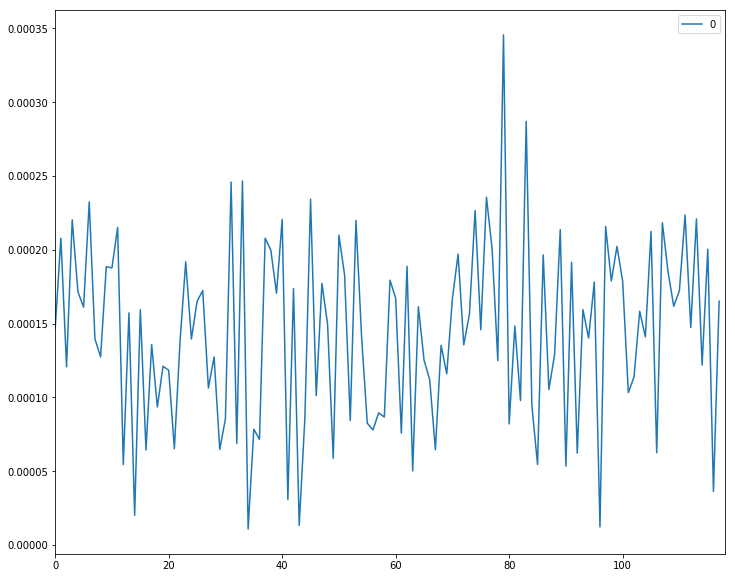

In [115]:
realized_volat.plot(figsize=(12, 10))
plt.show()

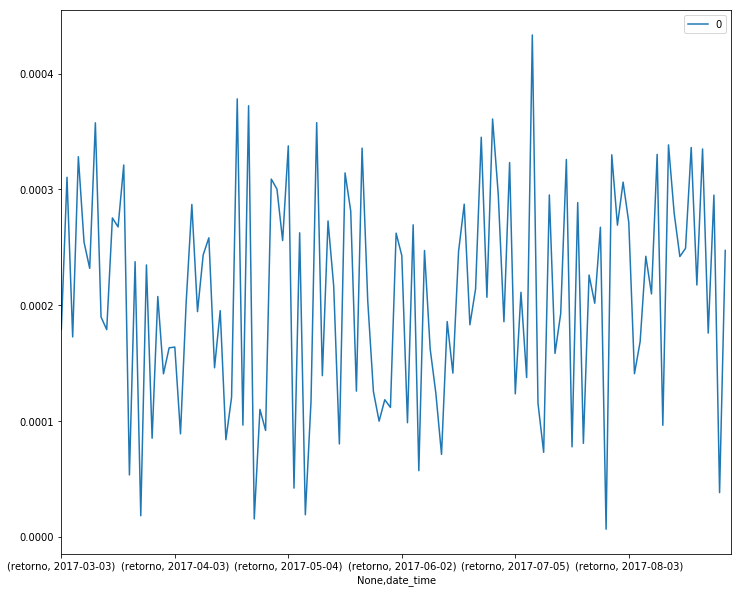

In [96]:
bipower_var.plot(figsize=(12, 10))
plt.show()

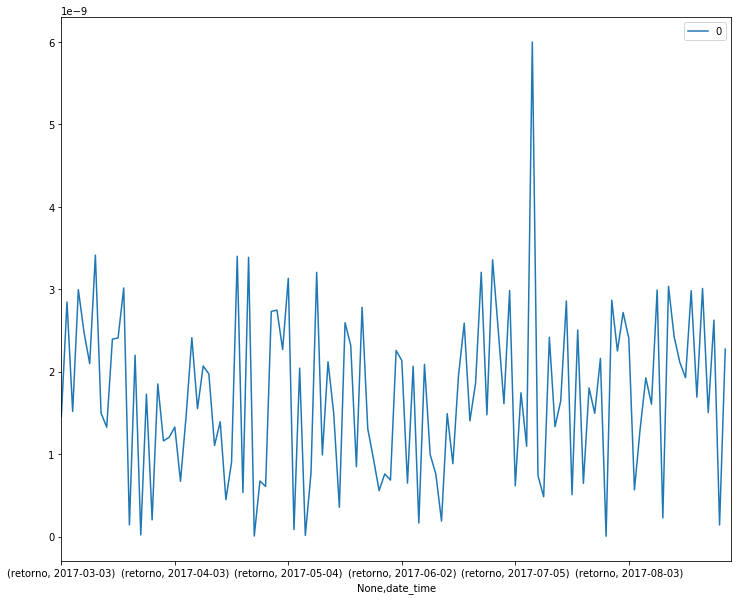

In [97]:
tripower_quart.plot(figsize=(12, 10))
plt.show()